In [ ]:
#!pip install --upgrade pip

In [ ]:
!pip install control

!pip install plotly
!pip install nbformat
!pip install SciencePlots 
!pip install latex


In [1]:
# importa os módulos necessários 

import numpy as np
import matplotlib.pyplot as plt
import sympy as sym
from scipy.integrate import odeint
from matplotlib import animation
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import PillowWriter

import control as ct
import slycot as slc
import scienceplots
#import latex
plt.style.use(['science','no-latex'])


# 1 Modelagem Simbólica pelo módulo Sympy

In [2]:
# Definindo as variáveis simbólicas

# Constantes
M, m1, m2, l1, l2,J1, J2, g, t, f0, f1, f2 = sym.symbols('M m1 m2 l1 l2 J1 J2 g t  f0 f1 f2')

# Variáveis
phi1, phi2, x ,u, theta1, theta2 = sym.symbols(r'phi1 phi2 x u theta1 theta2', cls=sym.Function) # funções para se trabalhar em cima


In [3]:
# Definindo as derivadas no tempo 

x = x(t)  # Posição x do carro 
u = u(t)  # Variável de controle
#u_l = u # Variável de controle (Usada na parte linear)
phi1 = phi1(t) # Ângulo do pêndulo inferior
phi2 = phi2(t) # Ângulo do pêndulo superior
theta1 = theta1(t) # Ângulo do pêndulo inferior linearizado 
theta2 = theta2(t) # Ângulo do pêndulo superior linearizado

x_d = sym.diff(x, t) # Velocidade do carro
phi1_d = sym.diff(phi1, t) # Velocidade ângular do pêndulo inferior
phi2_d = sym.diff(phi2, t) # Velocidade ângular do pêndulo superior

x_dd = sym.diff(x_d, t) # Aceleração do carro
phi1_dd = sym.diff(phi1_d, t) # Aceleração ângular do pêndulo inferior
phi2_dd = sym.diff(phi2_d, t) # Aceleração angular do pêndulo superior

# Simplificação
#dpdp2 = phi2_d*phi2_d
phi2_d_2 = phi2_d*phi2_d

#dpdp1 = phi1_d*phi1_d
phi1_d_2 = phi1_d*phi1_d

#dxdx = x_d*x_d
x_d_2 = x_d*x_d


### Energia Cinética e Potencial do Carro:
$$
\begin{align}
K_{c}= \frac{1}{2}M v^2 = \frac{1}{2}M \dot{x}^2
\end{align}
$$
$$
\begin{align}
P_c = 0
\end{align}
$$

In [4]:
# Energia cinética e potencial carro:
Kc = 1/2 * M *x_d_2
Pc = 0

### Energia Cinética e Potencial do pêndulo inferior:
$$
\begin{align}
K_{m_1} &= \frac{1}{2}m_1v_{x_1}^2 + \frac{1}{2}m_1v_{y_1}^2 + \frac{1}{2}J_1\omega_1^2
\end{align}
$$
$$
\begin{align}
P_{m_1} = m_1 g l_1 \cos(\phi_1)
\end{align}
$$

In [5]:
v_x1 = sym.diff(x+l1*sym.sin(phi1),t)
v_x1_2 = v_x1**2

In [6]:
v_y1 = sym.diff(l1*sym.cos(phi1),t)
v_y1_2 = v_y1**2

# velocidade angular
w_1 = phi1_d 

In [7]:
K_m1 = 1/2 * m1 * v_x1_2 + 1/2 * m1 * v_y1_2 + 1/2 * J1 * w_1**2
K_m1

0.5*J1*Derivative(phi1(t), t)**2 + 0.5*l1**2*m1*sin(phi1(t))**2*Derivative(phi1(t), t)**2 + 0.5*m1*(l1*cos(phi1(t))*Derivative(phi1(t), t) + Derivative(x(t), t))**2

In [8]:
P_m1 = m1*g*l1*sym.cos(phi1)
P_m1

g*l1*m1*cos(phi1(t))

### Energia Cinética e Potencial do pêndulo superior:

$$
\begin{align}
K_{m_2} &= K'_{m_2} + K''_{m_2}
\end{align}
$$
$$
\begin{align}
K'_{m_2} &= \frac{1}{2}m_2v_{x_2}^2 + \frac{1}{2}m_2v_{y_2}^2 
\end{align}
$$
$$
\begin{align}
K''_{m_2} &= \frac{1}{2} J_2 \omega_2^2 = \frac{1}{2} J_2 \phi_2^2  
\end{align}
$$
$$
\begin{align}
P_{m_2} = m_1 g l_1 \cos(\phi_1) + m_2 g (2l_1 \cos(\phi_1) + l_2 \cos(\phi_2))
\end{align}
$$

In [9]:
v_x2 = sym.diff(x+2*l1*sym.sin(phi1)+l2*sym.sin(phi2),t)
v_x2_2 = v_x2**2

In [10]:
#v_y2 = sym.diff(2*l1*sym.cos(phi1) + l2*sym.cos(phi2),t)
v_y2 = sym.diff(-2*l1*sym.cos(phi1) - l2*sym.cos(phi2),t)
v_y2_2 = v_y2**2

In [ ]:
# velocidade angular
w_2 = phi2_d**2

In [12]:
K_m22 = 1/2 * J2 * w_2 

In [13]:
K_m2 = 1/2 * m2*v_x2_2 + 1/2 * m2*v_y2_2 + K_m22
K_m2

0.5*J2*Derivative(phi2(t), t)**2 + 0.5*m2*(2*l1*sin(phi1(t))*Derivative(phi1(t), t) + l2*sin(phi2(t))*Derivative(phi2(t), t))**2 + 0.5*m2*(2*l1*cos(phi1(t))*Derivative(phi1(t), t) + l2*cos(phi2(t))*Derivative(phi2(t), t) + Derivative(x(t), t))**2

In [14]:
P_m2 = m2*g*(2*l1*sym.cos(phi1)+l2*sym.cos(phi2))
P_m2

g*m2*(2*l1*cos(phi1(t)) + l2*cos(phi2(t)))

### Equação de Lagrange:
$$
\begin{align}
L = K-P
\end{align}
$$

In [15]:
# Equação de Lagrange: L = T-U

# Energia cinética e potencial total:
P_total = Pc + P_m1 + P_m2
K_total = Kc + K_m1 + K_m2 
L = K_total.simplify() - P_total.simplify()
L

0.5*J1*Derivative(phi1(t), t)**2 + 0.5*J2*Derivative(phi2(t), t)**2 + 0.5*M*Derivative(x(t), t)**2 - g*(l1*m1*cos(phi1(t)) + m2*(2*l1*cos(phi1(t)) + l2*cos(phi2(t)))) + 0.5*l1**2*m1*Derivative(phi1(t), t)**2 + 2.0*l1**2*m2*Derivative(phi1(t), t)**2 + 2.0*l1*l2*m2*cos(phi1(t) - phi2(t))*Derivative(phi1(t), t)*Derivative(phi2(t), t) + 1.0*l1*m1*cos(phi1(t))*Derivative(phi1(t), t)*Derivative(x(t), t) + 2.0*l1*m2*cos(phi1(t))*Derivative(phi1(t), t)*Derivative(x(t), t) + 0.5*l2**2*m2*Derivative(phi2(t), t)**2 + 1.0*l2*m2*cos(phi2(t))*Derivative(phi2(t), t)*Derivative(x(t), t) + 0.5*m1*Derivative(x(t), t)**2 + 0.5*m2*Derivative(x(t), t)**2

In [16]:
K_total.simplify()

0.5*J1*Derivative(phi1(t), t)**2 + 0.5*J2*Derivative(phi2(t), t)**2 + 0.5*M*Derivative(x(t), t)**2 + 0.5*l1**2*m1*Derivative(phi1(t), t)**2 + 2.0*l1**2*m2*Derivative(phi1(t), t)**2 + 2.0*l1*l2*m2*cos(phi1(t) - phi2(t))*Derivative(phi1(t), t)*Derivative(phi2(t), t) + 1.0*l1*m1*cos(phi1(t))*Derivative(phi1(t), t)*Derivative(x(t), t) + 2.0*l1*m2*cos(phi1(t))*Derivative(phi1(t), t)*Derivative(x(t), t) + 0.5*l2**2*m2*Derivative(phi2(t), t)**2 + 1.0*l2*m2*cos(phi2(t))*Derivative(phi2(t), t)*Derivative(x(t), t) + 0.5*m1*Derivative(x(t), t)**2 + 0.5*m2*Derivative(x(t), t)**2

### Equação de Lagrange para a variável de estado $\dot{x}$
$$
\begin{align} 
    \frac{\mathrm{d} }{\mathrm{d} t}\left ( \frac{\partial L}{\partial \dot{x}} \right )-\left ( \frac{\partial L}{x} \right )= u- f_0 \dot{x}
\end{align}
$$

In [17]:
# Equaçoes das variaveis generalizadas:

# Coordenada generalizada X:
eq_x = sym.diff(sym.diff(L,x_d),t)-sym.diff(L,x)-u+f0*x_d

eq_x


1.0*M*Derivative(x(t), (t, 2)) + f0*Derivative(x(t), t) - 1.0*l1*m1*sin(phi1(t))*Derivative(phi1(t), t)**2 + 1.0*l1*m1*cos(phi1(t))*Derivative(phi1(t), (t, 2)) - 2.0*l1*m2*sin(phi1(t))*Derivative(phi1(t), t)**2 + 2.0*l1*m2*cos(phi1(t))*Derivative(phi1(t), (t, 2)) - 1.0*l2*m2*sin(phi2(t))*Derivative(phi2(t), t)**2 + 1.0*l2*m2*cos(phi2(t))*Derivative(phi2(t), (t, 2)) + 1.0*m1*Derivative(x(t), (t, 2)) + 1.0*m2*Derivative(x(t), (t, 2)) - u(t)

In [18]:
sym.diff(L,x)

0

In [19]:
sym.diff(L,x_d)

1.0*M*Derivative(x(t), t) + 1.0*l1*m1*cos(phi1(t))*Derivative(phi1(t), t) + 2.0*l1*m2*cos(phi1(t))*Derivative(phi1(t), t) + 1.0*l2*m2*cos(phi2(t))*Derivative(phi2(t), t) + 1.0*m1*Derivative(x(t), t) + 1.0*m2*Derivative(x(t), t)

### A equação de Lagrange para a variável de estado $\phi_1$ é:
$$
\begin{align} 
     \frac{\mathrm{d} }{\mathrm{d} t}\left ( \frac{\partial L}{\partial \dot{\phi_1}} \right )-\left ( \frac{\partial L}{\phi_1} \right )=-(f_1 + f_2)\dot{\phi_1} + f_2 \dot{\phi_2}
\end{align} 
$$

In [20]:
# Coordenada generalizada phi1:
eqn_phi1 = sym.diff(sym.diff(L,phi1_d),t)-sym.diff(L,phi1)+(f1+f2)*phi1_d -f2*phi2_d

eqn_phi1.simplify()

1.0*J1*Derivative(phi1(t), (t, 2)) + 1.0*f1*Derivative(phi1(t), t) + 1.0*f2*Derivative(phi1(t), t) - 1.0*f2*Derivative(phi2(t), t) - 1.0*g*l1*m1*sin(phi1(t)) - 2.0*g*l1*m2*sin(phi1(t)) + 1.0*l1**2*m1*Derivative(phi1(t), (t, 2)) + 4.0*l1**2*m2*Derivative(phi1(t), (t, 2)) + 2.0*l1*l2*m2*sin(phi1(t) - phi2(t))*Derivative(phi2(t), t)**2 + 2.0*l1*l2*m2*cos(phi1(t) - phi2(t))*Derivative(phi2(t), (t, 2)) + 1.0*l1*m1*cos(phi1(t))*Derivative(x(t), (t, 2)) + 2.0*l1*m2*cos(phi1(t))*Derivative(x(t), (t, 2))

In [21]:
sym.diff(L,phi1).simplify()    

l1*(g*(m1 + 2*m2)*sin(phi1(t)) - 2.0*l2*m2*sin(phi1(t) - phi2(t))*Derivative(phi1(t), t)*Derivative(phi2(t), t) - 1.0*m1*sin(phi1(t))*Derivative(phi1(t), t)*Derivative(x(t), t) - 2.0*m2*sin(phi1(t))*Derivative(phi1(t), t)*Derivative(x(t), t))

In [22]:
sym.diff(L,phi1_d).simplify()   

1.0*J1*Derivative(phi1(t), t) + 1.0*l1**2*m1*Derivative(phi1(t), t) + 4.0*l1**2*m2*Derivative(phi1(t), t) + 2.0*l1*l2*m2*cos(phi1(t) - phi2(t))*Derivative(phi2(t), t) + 1.0*l1*m1*cos(phi1(t))*Derivative(x(t), t) + 2.0*l1*m2*cos(phi1(t))*Derivative(x(t), t)

In [23]:
sym.diff(sym.diff(L,phi1_d),t)

1.0*J1*Derivative(phi1(t), (t, 2)) + 1.0*l1**2*m1*Derivative(phi1(t), (t, 2)) + 4.0*l1**2*m2*Derivative(phi1(t), (t, 2)) - 2.0*l1*l2*m2*(Derivative(phi1(t), t) - Derivative(phi2(t), t))*sin(phi1(t) - phi2(t))*Derivative(phi2(t), t) + 2.0*l1*l2*m2*cos(phi1(t) - phi2(t))*Derivative(phi2(t), (t, 2)) - 1.0*l1*m1*sin(phi1(t))*Derivative(phi1(t), t)*Derivative(x(t), t) + 1.0*l1*m1*cos(phi1(t))*Derivative(x(t), (t, 2)) - 2.0*l1*m2*sin(phi1(t))*Derivative(phi1(t), t)*Derivative(x(t), t) + 2.0*l1*m2*cos(phi1(t))*Derivative(x(t), (t, 2))

### Para a variável $\phi_2$, temos a seguinte equação de Lagrange :
$$
\begin{align} 
    \frac{\mathrm{d} }{\mathrm{d} t}\frac{\partial L}{\partial \dot{\phi_2}}-\frac{\partial L}{\partial \phi_2}=f_2\dot{\phi_1} - f_2 \dot{\phi_2}
\end{align} 
$$


In [24]:

# Coordenada generalizada phi2:
eqn_phi2 = sym.diff(sym.diff(L,phi2_d),t)-sym.diff(L,phi2)-f2*phi1_d + f2*phi2_d

eqn_phi2.simplify()


1.0*J2*Derivative(phi2(t), (t, 2)) - 1.0*f2*Derivative(phi1(t), t) + 1.0*f2*Derivative(phi2(t), t) - 1.0*g*l2*m2*sin(phi2(t)) - 2.0*l1*l2*m2*sin(phi1(t) - phi2(t))*Derivative(phi1(t), t)**2 + 2.0*l1*l2*m2*cos(phi1(t) - phi2(t))*Derivative(phi1(t), (t, 2)) + 1.0*l2**2*m2*Derivative(phi2(t), (t, 2)) + 1.0*l2*m2*cos(phi2(t))*Derivative(x(t), (t, 2))

In [25]:
sym.diff(L,phi2)

g*l2*m2*sin(phi2(t)) + 2.0*l1*l2*m2*sin(phi1(t) - phi2(t))*Derivative(phi1(t), t)*Derivative(phi2(t), t) - 1.0*l2*m2*sin(phi2(t))*Derivative(phi2(t), t)*Derivative(x(t), t)

In [26]:
sym.diff(L,phi2_d)

1.0*J2*Derivative(phi2(t), t) + 2.0*l1*l2*m2*cos(phi1(t) - phi2(t))*Derivative(phi1(t), t) + 1.0*l2**2*m2*Derivative(phi2(t), t) + 1.0*l2*m2*cos(phi2(t))*Derivative(x(t), t)

In [27]:
sym.diff(sym.diff(L,phi2_d),t)

1.0*J2*Derivative(phi2(t), (t, 2)) - 2.0*l1*l2*m2*(Derivative(phi1(t), t) - Derivative(phi2(t), t))*sin(phi1(t) - phi2(t))*Derivative(phi1(t), t) + 2.0*l1*l2*m2*cos(phi1(t) - phi2(t))*Derivative(phi1(t), (t, 2)) + 1.0*l2**2*m2*Derivative(phi2(t), (t, 2)) - 1.0*l2*m2*sin(phi2(t))*Derivative(phi2(t), t)*Derivative(x(t), t) + 1.0*l2*m2*cos(phi2(t))*Derivative(x(t), (t, 2))

# Solução Numérica (Scipy)

In [ ]:
# # Solução das equaçoes das variáveis generalizadas
# # Solução para X
# sol_xdd = sym.solve(eqnx, x_dd)[0]
# #sol_xdd = sym.solve([eqnx], (x_dd), simplify=False, rational=False)#[0]

# # Solução para phi1
# sol_phi1dd = sym.solve(eqn_phi1, phi1_dd)[0]
# #sol_phi1dd = sym.solve([eqn_phi1], (phi1_dd), simplify=False, rational=False)#[0]

# # Solução para phi1
# sol_phi2dd = sym.solve(eqn_phi2, phi2_dd)[0]
# #sol_phi2dd = sym.solve([eqn_phi2], (phi2_dd), simplify=False, rational=False)#[0]

In [ ]:
# Soluciona o sistema de equações das variaveis generalizadas
sols = sym.solve([eq_x, eqn_phi1, eqn_phi2], (x_dd,phi1_dd,phi2_dd),
                simplify=False, rational=True)

In [ ]:
# Soluciona o sistema de equações das variaveis generalizadas para X
#solset_x = sym.solveset([eq_x, eqn_phi1,eqn_phi2],x_dd)
#solset_x

### Dinâmica Não Linear

Definindo as equações

$$
\begin{align}
\frac{\mathrm{d} ^2 x}{\mathrm{d} t^2} = \frac{\mathrm{d} \omega  }{\mathrm{d} t} \\
\frac{\mathrm{d} x }{\mathrm{d} t} = \omega
\end{align}
$$
Para $X$

$$
\begin{align}
\frac{\mathrm{d} ^2 \phi}{\mathrm{d} t^2} = \frac{\mathrm{d} \zeta }{\mathrm{d} t} \\
\frac{\mathrm{d} \phi }{\mathrm{d} t} = \zeta
\end{align}
$$
Para cada $\phi\in (\phi_1, \phi_2)$

In [ ]:
# Converter a expressão simbólica em uma função numérica
do1dt_f = sym.lambdify((t, M, m1, m2, g , J1, J2, l1, l2, f0, f1, f2, u, x, phi1, phi2, x_d, phi1_d, phi2_d), sols[x_dd])
dxdt_f = sym.lambdify(x_d, x_d)

dz1dt_f = sym.lambdify((t, M, m1, m2, g , J1, J2, l1, l2, f0, f1, f2, u, x, phi1, phi2, x_d, phi1_d, phi2_d), sols[phi1_dd])
dphi1dt_f = sym.lambdify(phi1_d, phi1_d)

dz2dt_f = sym.lambdify((t, M, m1, m2, g, J1, J2, l1, l2, f0, f1, f2, u, x, phi1, phi2, x_d, phi1_d, phi2_d), sols[phi2_dd])
dphi2dt_f = sym.lambdify(phi2_d, phi2_d)

Define o sistema de ODE para o python $S = (X,\omega,\phi_1,\zeta_1,\phi_2,\zeta_2)$

In [ ]:
def dSdt(S, t):
    x, o1, phi1, z1, phi2, z2 = S
    
    return [
        dxdt_f(o1),
        do1dt_f(t, M, m1, m2, g, J1, J2, l1, l2, f0, f1, f2, u, x, phi1, phi2, o1, z1, z2),
        
        dphi1dt_f(z1),
        dz1dt_f(t, M, m1, m2, g, J1, J2, l1, l2, f0, f1, f2, u, x, phi1, phi2, o1, z1, z2),
        
        dphi2dt_f(z2),
        dz2dt_f(t, M, m1, m2, g, J1, J2, l1, l2, f0, f1, f2, u, x, phi1, phi2, o1, z1, z2),
    ]

In [ ]:
"""# Tempo de simulação
t = np.arange(0,50,0.001)

# Parâmetros do sistema
M = 1.2#1
m1 =0.4#1
m2 = 0.22#1
u = 0
J1=0.0407#0.00083
J2=0.359#0.00083
l1=2*0.04064#0.05
l2=2*0.6878#0.05
g=9.81
f0=0.5#0.01
f1=0.2#0.007
f2=0.2#0.007

# Solução numérica
soluODE = odeint(dSdt, y0=[0.0, np.deg2rad(5), np.deg2rad(5), 0.0, 0, 0], t=t)"""

In [ ]:
# Tempo de simulação
t = np.arange(0,15,0.01)
#t = np.linspace(0,10,5000)

# Parâmetros do sistema
M = 1
m1 = 1
m2 = 1
u = 0
J1=0.00083
J2=0.00083
l1=0.05
l2=0.05
g=9.81
f0=.9
f1=0.007
f2=0.007

# Solução numérica
soluODE = odeint(dSdt, y0=[0.0, np.deg2rad(1), np.deg2rad(1), 0.0, 0.0, 0.0], t=t)

In [ ]:
#plt.style.use(['ggplot'])
plt.figure(figsize=(10,8))
# plt.title('Resposta em malha aberta')
plt.subplot(3,1,1)
plt.plot(t, soluODE.T[0],'r',linewidth=1.3,label='Pos. Carro')
# plt.xlabel('Amostras [s]',fontsize=11)
plt.ylabel('Position [m]',fontsize=11)
plt.grid(True)
plt.legend(loc='lower right',fontsize='small')

plt.subplot(3,1,2)
plt.plot(t, np.rad2deg(soluODE.T[1]),'b',linewidth=1.3,label='Pos. Pendulo Inferior')
# plt.xlabel('Amostras [s]',fontsize=11)
plt.ylabel('Position [Graus]',fontsize=11)
plt.grid(True)
plt.legend(loc='upper right',fontsize='small')

plt.subplot(3,1,3)
plt.plot(t, np.rad2deg(soluODE.T[2]),'g',linewidth=1.3,label='Pos. Pendulo Superior')
plt.xlabel('Segundos [s]',fontsize=11)
plt.ylabel('Position [Graus]',fontsize=11)
plt.grid(True)
plt.legend(loc='upper right',fontsize='small')


plt.savefig('Cap2_resposta_natural_ma_nl.png', dpi=250,bbox_inches='tight')
plt.show()

In [ ]:

plt.figure(figsize=(10,8))
# plt.title('Resposta em malha aberta')
plt.subplot(3,1,1)
plt.plot(t, soluODE.T[3],'b',linewidth=1.5,label='Pos. X')
# plt.xlabel('Amostras [s]',fontsize=11)
plt.ylabel('Velocidade [m/s]',fontsize=11)
plt.grid(True)
plt.legend(loc='upper right',fontsize='small')

plt.subplot(3,1,2)
plt.plot(t, soluODE.T[4],'r',linewidth=1.5,label='Pos. pendulo inferior')
# plt.xlabel('Amostras [s]',fontsize=11)
plt.ylabel('Velocidade Angular [rad/s]',fontsize=11)
plt.grid(True)
plt.legend(loc='upper right',fontsize='small')

plt.subplot(3,1,3)
plt.plot(t, soluODE.T[5],'g',linewidth=1.5,label='Pos. pendulo superior')
plt.xlabel('Segundos [s]',fontsize=11)
plt.ylabel('Velocidade Angular [rad/s]',fontsize=11)
plt.grid(True)
plt.legend(loc='upper right',fontsize='small')
plt.show()

# DINÂMICA NÃO LINEAR

$$
\begin{align}
q_p = \begin{bmatrix}
x\\ \phi_1
\\ \phi_2
\end{bmatrix},\;\;\;\;\;\dot{q}_p = \begin{bmatrix}
\dot{x}\\ \dot{\phi}_1
\\ \dot{\phi}_2
\end{bmatrix},\;\;\;\;\; \ddot{q}_p = \begin{bmatrix}
\ddot{x}\\ \ddot{\phi}_1
\\ \ddot{\phi}_2
\end{bmatrix},\;\;\;\;\; u_p = \begin{bmatrix}
u\\ 0
\\ 0
\end{bmatrix}
\end{align}
$$

In [80]:
# Matriz dos estados
#q = sym.Matrix([x,theta1,theta2])
q = sym.Matrix([x,phi1,phi2])

# Matriz das derivadas de estados
q_d = sym.Matrix([(x_d,phi1_d,phi2_d)])

# Matriz das 2º derivadas de estados
q_dd = sym.Matrix([(x_dd,phi1_dd,phi2_dd)])

# Matriz estados total
q_ef = sym.Matrix([q,q_d.transpose()])
q_ef1 = sym.Matrix([q_d.transpose(),q_dd.transpose()])
x_ = sym.Matrix([x,phi1,phi2,x_d,phi1_d,phi2_d])

$$
\begin{align}
H(q_p)\ddot{q_p} + N(q_p,\dot{q_p}) + W(q_p) = V(q_p)u_p
\end{align}
$$
$$
\begin{align}
\ddot{q_p} = -\frac{N(q_p,\dot{q_p})}{H(q_p)} - \frac{W(q_p)}{H(q_p)} + \frac{V(q_p)u_p}{H(q_p)}
\end{align}
$$



In [81]:
# Matriz H
H_nl = sym.Matrix((sym.diff(eq_x,q_dd),sym.diff(eqn_phi1,q_dd),sym.diff(eqn_phi2,q_dd)))
H_nl

Matrix([
[                        1.0*M + 1.0*m1 + 1.0*m2, 1.0*l1*m1*cos(phi1(t)) + 2.0*l1*m2*cos(phi1(t)),              1.0*l2*m2*cos(phi2(t))],
[1.0*l1*m1*cos(phi1(t)) + 2.0*l1*m2*cos(phi1(t)),            1.0*J1 + 1.0*l1**2*m1 + 4.0*l1**2*m2, 2.0*l1*l2*m2*cos(phi1(t) - phi2(t))],
[                         1.0*l2*m2*cos(phi2(t)),             2.0*l1*l2*m2*cos(phi1(t) - phi2(t)),               1.0*J2 + 1.0*l2**2*m2]])

In [82]:
# Simplificação de H
# Constantes
a0, a1, a2, a3, a4, a5 = sym.symbols('a0 a1 a2 a3 a4 a5')

H_nl_simplificada = sym.Matrix(((a0, a1, a2),(a1 ,a3, a4),(a2,a4, a5)))
H_nl_simplificada

Matrix([
[a0, a1, a2],
[a1, a3, a4],
[a2, a4, a5]])

In [83]:
# Matriz H inversa:
#H_nl_inv = H_nl.inv()
H_nl_simplificada_inv = H_nl_simplificada.inv()
H_nl_simplificada_inv

Matrix([
[ (a3*a5 - a4**2)/(a0*a3*a5 - a0*a4**2 - a1**2*a5 + 2*a1*a2*a4 - a2**2*a3), (-a1*a5 + a2*a4)/(a0*a3*a5 - a0*a4**2 - a1**2*a5 + 2*a1*a2*a4 - a2**2*a3),  (a1*a4 - a2*a3)/(a0*a3*a5 - a0*a4**2 - a1**2*a5 + 2*a1*a2*a4 - a2**2*a3)],
[(-a1*a5 + a2*a4)/(a0*a3*a5 - a0*a4**2 - a1**2*a5 + 2*a1*a2*a4 - a2**2*a3),  (a0*a5 - a2**2)/(a0*a3*a5 - a0*a4**2 - a1**2*a5 + 2*a1*a2*a4 - a2**2*a3), (-a0*a4 + a1*a2)/(a0*a3*a5 - a0*a4**2 - a1**2*a5 + 2*a1*a2*a4 - a2**2*a3)],
[ (a1*a4 - a2*a3)/(a0*a3*a5 - a0*a4**2 - a1**2*a5 + 2*a1*a2*a4 - a2**2*a3), (-a0*a4 + a1*a2)/(a0*a3*a5 - a0*a4**2 - a1**2*a5 + 2*a1*a2*a4 - a2**2*a3),  (a0*a3 - a1**2)/(a0*a3*a5 - a0*a4**2 - a1**2*a5 + 2*a1*a2*a4 - a2**2*a3)]])

In [84]:
# Matriz N
N_nl = sym.Matrix(([sym.diff(eq_x,q_d)],[sym.diff(eqn_phi1,q_d)],[sym.diff(eqn_phi2,q_d)]))*q_d.transpose()
N_nl

Matrix([
[                                                                              f0*Derivative(x(t), t) - 2.0*l2*m2*sin(phi2(t))*Derivative(phi2(t), t)**2 + (-2.0*l1*m1*sin(phi1(t))*Derivative(phi1(t), t) - 4.0*l1*m2*sin(phi1(t))*Derivative(phi1(t), t))*Derivative(phi1(t), t)],
[(f1 + f2)*Derivative(phi1(t), t) + (-f2 - 2.0*l1*l2*m2*(Derivative(phi1(t), t) - Derivative(phi2(t), t))*sin(phi1(t) - phi2(t)) + 2.0*l1*l2*m2*sin(phi1(t) - phi2(t))*Derivative(phi1(t), t) + 2.0*l1*l2*m2*sin(phi1(t) - phi2(t))*Derivative(phi2(t), t))*Derivative(phi2(t), t)],
[       f2*Derivative(phi2(t), t) + (-f2 - 2.0*l1*l2*m2*(Derivative(phi1(t), t) - Derivative(phi2(t), t))*sin(phi1(t) - phi2(t)) - 2.0*l1*l2*m2*sin(phi1(t) - phi2(t))*Derivative(phi1(t), t) - 2.0*l1*l2*m2*sin(phi1(t) - phi2(t))*Derivative(phi2(t), t))*Derivative(phi1(t), t)]])

In [85]:
# Simplificação de N
N_nl_simplificada = sym.Matrix(((f0*x_d - a1*sym.sin(phi1)*phi1_d*phi1_d - a2*sym.sin(phi2)*phi2_d*phi2_d),
                                ((f1+f2)*phi1_d - f2*phi2_d +a4*phi2_d*phi2_d*sym.sin(phi1-phi2)),
                                (-f2*phi1_d+f2*phi2_d - a4*phi1_d*phi1_d*sym.sin(phi1-phi2))))
N_nl_simplificada

Matrix([
[   -a1*sin(phi1(t))*Derivative(phi1(t), t)**2 - a2*sin(phi2(t))*Derivative(phi2(t), t)**2 + f0*Derivative(x(t), t)],
[a4*sin(phi1(t) - phi2(t))*Derivative(phi2(t), t)**2 - f2*Derivative(phi2(t), t) + (f1 + f2)*Derivative(phi1(t), t)],
[      -a4*sin(phi1(t) - phi2(t))*Derivative(phi1(t), t)**2 - f2*Derivative(phi1(t), t) + f2*Derivative(phi2(t), t)]])

In [86]:
# Matriz W
W_nl = sym.Matrix([0,-g*l1*sym.sin(phi1)*(m1+2*m2),-g*m2*l2*sym.sin(phi2)])
W_nl

Matrix([
[                             0],
[-g*l1*(m1 + 2*m2)*sin(phi1(t))],
[         -g*l2*m2*sin(phi2(t))]])

In [87]:
# Simplificação de W
W_nl_simplificada = sym.Matrix([0,-a1*g*sym.sin(phi1),-a2*g*sym.sin(phi2)])
W_nl_simplificada

Matrix([
[                 0],
[-a1*g*sin(phi1(t))],
[-a2*g*sin(phi2(t))]])

In [88]:
S_nl = N_nl_simplificada + W_nl_simplificada
S_nl

Matrix([
[                        -a1*sin(phi1(t))*Derivative(phi1(t), t)**2 - a2*sin(phi2(t))*Derivative(phi2(t), t)**2 + f0*Derivative(x(t), t)],
[-a1*g*sin(phi1(t)) + a4*sin(phi1(t) - phi2(t))*Derivative(phi2(t), t)**2 - f2*Derivative(phi2(t), t) + (f1 + f2)*Derivative(phi1(t), t)],
[       -a2*g*sin(phi2(t)) - a4*sin(phi1(t) - phi2(t))*Derivative(phi1(t), t)**2 - f2*Derivative(phi1(t), t) + f2*Derivative(phi2(t), t)]])

In [89]:
# Matriz V
V_nl = sym.Matrix([u, 0, 0])
V_nl

Matrix([
[u(t)],
[   0],
[   0]])

In [90]:
- H_nl_simplificada_inv*S_nl -H_nl_simplificada.inv() * V_nl

Matrix([
[  -(a1*a4 - a2*a3)*(-a2*g*sin(phi2(t)) - a4*sin(phi1(t) - phi2(t))*Derivative(phi1(t), t)**2 - f2*Derivative(phi1(t), t) + f2*Derivative(phi2(t), t))/(a0*a3*a5 - a0*a4**2 - a1**2*a5 + 2*a1*a2*a4 - a2**2*a3) - (-a1*a5 + a2*a4)*(-a1*g*sin(phi1(t)) + a4*sin(phi1(t) - phi2(t))*Derivative(phi2(t), t)**2 - f2*Derivative(phi2(t), t) + (f1 + f2)*Derivative(phi1(t), t))/(a0*a3*a5 - a0*a4**2 - a1**2*a5 + 2*a1*a2*a4 - a2**2*a3) - (a3*a5 - a4**2)*(-a1*sin(phi1(t))*Derivative(phi1(t), t)**2 - a2*sin(phi2(t))*Derivative(phi2(t), t)**2 + f0*Derivative(x(t), t))/(a0*a3*a5 - a0*a4**2 - a1**2*a5 + 2*a1*a2*a4 - a2**2*a3) - (a3*a5 - a4**2)*u(t)/(a0*a3*a5 - a0*a4**2 - a1**2*a5 + 2*a1*a2*a4 - a2**2*a3)],
[-(-a0*a4 + a1*a2)*(-a2*g*sin(phi2(t)) - a4*sin(phi1(t) - phi2(t))*Derivative(phi1(t), t)**2 - f2*Derivative(phi1(t), t) + f2*Derivative(phi2(t), t))/(a0*a3*a5 - a0*a4**2 - a1**2*a5 + 2*a1*a2*a4 - a2**2*a3) - (a0*a5 - a2**2)*(-a1*g*sin(phi1(t)) + a4*sin(phi1(t) - phi2(t))*Derivative(phi2(t), t)**2

In [91]:
# Matrizes Não linear
Anl = sym.Matrix.vstack(q_d.transpose(), -H_nl_simplificada.inv() * S_nl)
Anl

Matrix([
[                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             Derivative(x(t), t)],
[                                                                                                                                                                                                                                                                                                                                                                                          

In [92]:
Bnl = sym.Matrix.vstack(sym.zeros(3, 1), -H_nl_simplificada.inv() * V_nl)
Bnl

Matrix([
[                                                                              0],
[                                                                              0],
[                                                                              0],
[ -(a3*a5 - a4**2)*u(t)/(a0*a3*a5 - a0*a4**2 - a1**2*a5 + 2*a1*a2*a4 - a2**2*a3)],
[-(-a1*a5 + a2*a4)*u(t)/(a0*a3*a5 - a0*a4**2 - a1**2*a5 + 2*a1*a2*a4 - a2**2*a3)],
[ -(a1*a4 - a2*a3)*u(t)/(a0*a3*a5 - a0*a4**2 - a1**2*a5 + 2*a1*a2*a4 - a2**2*a3)]])

### Posição para estabilização
$$
\begin{align} 
    \left\{\begin{matrix}
x_0=\dot{x}_0=\ddot{x}_0=0\\ 
\phi_{1_0}=\dot{\phi_{1_0}}=\ddot{\phi_{1_0}} =0\\ 
\phi_{2_0}=\dot{\phi_{2_0}}=\ddot{\phi_{2_0}} =0
\end{matrix}\right. \rightarrow x_0=\begin{bmatrix}
0\\ 0
\\ 0
\\ 0
\\ 0
\\ 0
\end{bmatrix} ,\;\; \left\{\begin{matrix}
u=0
\end{matrix}\right. \rightarrow u_0=[0]
\end{align}
$$
$$
\begin{align}
\cos(\phi_1) \approx 1 \\
\cos(\phi_2) \approx 1 \\
\cos(\phi_1 - \phi_2) \approx 1 \\
\sin(\phi_1) = \theta_1 \\
\sin(\phi_2) = \theta_2
\end{align}
$$

In [ ]:
# Ponto de equilibrio - Linearização
#ponto_eq = {x:0,x_d:0,x_dd:0,phi1:0,phi2:0,phi1_d:0,phi2_d:0,phi2_dd:0,phi1_dd:0,sym.cos(phi1):1,\
#            sym.cos(phi2):1,sym.cos(phi1-phi2):1,sym.sin(phi1-phi2):phi1-phi2,sym.sin(phi1):phi1,sym.sin(phi2):phi2}


In [93]:
# Ponto de equilibrio - Linearização
ponto_eq = {x:0,x_d:0,x_dd:0,phi1:0,phi2:0,phi1_d:0,phi2_d:0,phi2_dd:0,phi1_dd:0, sym.cos(phi1):1,sym.cos(phi2):1, sym.cos(phi1-phi2):1}

In [94]:
# Valor dos parâmetros do sistema:


rev_parametros_valores = {g:9.91, f0:0.01, f1:0.007, f2:0.007, a0:3, a1:0.15, a2:0.05, a3:0.01333, a4:0.005, a5:0.00333}
#rev_parametros_valores = {g:9.91, f0:0, f1:0, f2:0, a0:3, a1:0.15, a2:0.05, a3:0.01333, a4:0.005, a5:0.00333}


In [95]:
# Matriz A Linear

A_0 = Anl.jacobian(q_ef)
A_0


Matrix([
[0,                                                                                                                                                                                                                                                                                                                                                                                                         0,                                                                                                                                                                                                                                                                                                                                                                                                         0,                                                                             1,                                                                                                                       

In [96]:
A_1 = A_0.subs(ponto_eq)
A_1


Matrix([
[0,                                                                              0,                                                                              0,                                                                             1,                                                                                                                                                                 0,                                                                                                                                                           0],
[0,                                                                              0,                                                                              0,                                                                             0,                                                                                                                                                                 1,                      

In [97]:
A_2 = A_1.subs(rev_parametros_valores)
A_2
A=np.matrix(A_2).astype(np.float64)
A_2

Matrix([
[0,                 0,                 0,                    1,                 0,                  0],
[0,                 0,                 0,                    0,                 1,                  0],
[0,                 0,                 0,                    0,                 0,                  1],
[0, -14.8848663747607,  1.66050279531399, -0.00778148791774192,   0.1636452660264, -0.093551714312088],
[0,  446.844285158147, -149.146957662933,     0.10013364530616, -6.31544305626348,   4.21123182443904],
[0, -447.440872988799,   347.81070526996,  -0.0335116608539655,  9.12761320720642,  -7.02059261459183]])

In [98]:
# Matriz B Linear
B_0 = Bnl.jacobian([u])
B_1 = B_0.subs(ponto_eq)
B_2 = B_1.subs(rev_parametros_valores)
B = np.matrix(B_2).astype(np.float64)
B_2



Matrix([
[                 0],
[                 0],
[                 0],
[-0.778148791774192],
[   10.013364530616],
[ -3.35116608539655]])

In [99]:
# Matriz C e D

C = np.array([[1, 0, 0, 0, 0, 0],
              [0, 1, 0, 0, 0, 0],
              [0, 0, 1, 0, 0, 0]])

# Matriz D
D = np.zeros((3,1))

# Controladores

## LQR Linear

### Sistema Contínuo

In [100]:
# Criando o sistema em State Space
sys_c_ma = ct.ss(A,B,C,D)
sys_c_ma



StateSpace(array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  1.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  1.00000000e+00],
       [ 0.00000000e+00, -1.48848664e+01,  1.66050280e+00,
        -7.78148792e-03,  1.63645266e-01, -9.35517143e-02],
       [ 0.00000000e+00,  4.46844285e+02, -1.49146958e+02,
         1.00133645e-01, -6.31544306e+00,  4.21123182e+00],
       [ 0.00000000e+00, -4.47440873e+02,  3.47810705e+02,
        -3.35116609e-02,  9.12761321e+00, -7.02059261e+00]]), array([[ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [-0.77814879],
       [10.01336453],
       [-3.35116609]]), array([[1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.]]), array([[0.],
       [0.],
       [0.]]

In [49]:
# Matriz de controlabilidade
Co = ct.ctrb(A, B) # Sis Contínuo

# Ranking da matriz de controlabilidade
ranking_Co = np.linalg.matrix_rank(Co)    
print('Rank da Matriz de controlabilidade:',ranking_Co)
Co

Rank da Matriz de controlabilidade: 6


array([[ 0.00000000e+00, -7.78148792e-01,  1.95820219e+00,
        -1.78052286e+02,  2.98788102e+03, -1.36754489e+05],
       [ 0.00000000e+00,  1.00133645e+01, -7.74292896e+01,
         5.94751415e+03, -1.19474063e+05,  5.23489479e+06],
       [ 0.00000000e+00, -3.35116609e+00,  1.14951367e+02,
        -7.15979696e+03,  1.79184938e+05, -7.50001257e+06],
       [-7.78148792e-01,  1.95820219e+00, -1.78052286e+02,
         2.98788102e+03, -1.36754489e+05,  3.63526149e+06],
       [ 1.00133645e+01, -7.74292896e+01,  5.94751415e+03,
        -1.19474063e+05,  5.23489479e+06, -1.44769856e+08],
       [-3.35116609e+00,  1.14951367e+02, -7.15979696e+03,
         1.79184938e+05, -7.50001257e+06,  2.16221229e+08]])

In [50]:
# Matriz de observabilidade
Ob = ct.obsv(A,C)

ranking_Ob = np.linalg.matrix_rank(Ob)    
print('Rank da Matriz de observabilidade:',ranking_Ob)
Ob

Rank da Matriz de observabilidade: 6


array([[ 1.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  1.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  1.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  1.00000000e+00],
       [ 0.00000000e+00, -1.48848664e+01,  1.66050280e+00,
        -7.78148792e-03,  1.63645266e-01, -9.35517143e-02],
       [ 0.00000000e+00,  4.46844285e+02, -1.49146958e+02,
         1.00133645e-01, -6.31544306e+00,  4.21123182e+00],
       [ 0.00000000e+00, -4.47440873e+02,  3.478

In [101]:
# Sintonia do Contolador Contínuo
Q = np.array([[400,0,0,0,0,0],[0,200,0,0,0,0],[0,0,200,0,0,0],[0,0,0,0,0,0],[0,0,0,0,0,0],[0,0,0,0,0,0]])
R1 = np.array([0.1])
R2 = np.array([1])
R3 = np.array([10])
R4 = np.array([100])


Kc1, Sc1, Pc1 = ct.lqr(sys_c_ma, Q, R1) # K - Ganhos do LQR
Kc2, Sc2, Pc2 = ct.lqr(sys_c_ma, Q, R2) # K - Ganhos do LQR
Kc3, Sc3, Pc3 = ct.lqr(sys_c_ma, Q, R3) # K - Ganhos do LQR
Kc4, Sc4, Pc4 = ct.lqr(sys_c_ma, Q, R4) # K - Ganhos do LQR



In [102]:
# Sistema em Malha fechada - Contínuo
sys_c_mf_1 = ct.ss(A - B*Kc1, B, C, D)
sys_c_mf_2 = ct.ss(A - B*Kc2, B, C, D)
sys_c_mf_3 = ct.ss(A - B*Kc3, B, C, D)
sys_c_mf_4 = ct.ss(A - B*Kc4, B, C, D)


# Para tracking
sys_c_mf_1_t = ct.ss(A - B*Kc1, B*Kc1[0][0], C, D)
sys_c_mf_2_t = ct.ss(A - B*Kc2, B*Kc2[0][0], C, D)
sys_c_mf_3_t = ct.ss(A - B*Kc3, B*Kc3[0][0], C, D)
sys_c_mf_4_t = ct.ss(A - B*Kc4, B*Kc4[0][0], C, D)

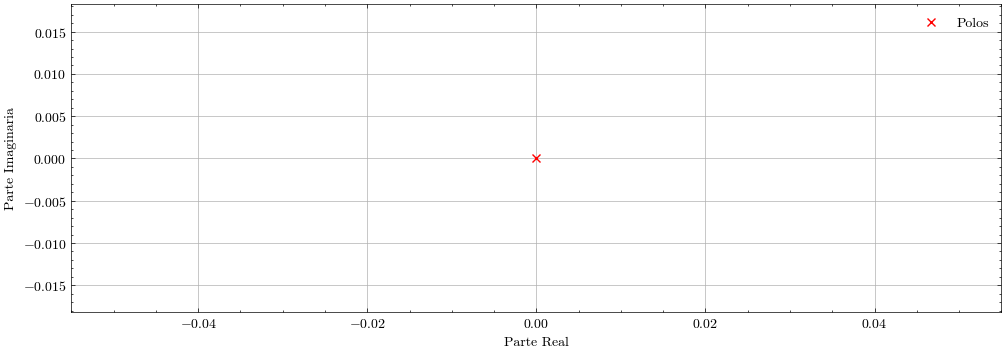

In [63]:
#  REPRESENTAÇÃO DOS POLOS NO PLANO CONTINUO
novo_sys_real = np.real(Pc)
novo_sys_imaginario = np.imag(Pc)

# Gráfico dos polos no plano complexo
plt.figure(figsize=(12, 4))
plt.plot(novo_sys_real,novo_sys_imaginario, 'rx', markersize=6, label='Polos')
plt.xlabel('Parte Real')
plt.ylabel('Parte Imaginaria')
plt.legend()
plt.grid(True)
plt.axis('equal')
plt.show()


In [64]:
# Simulações

# Simular o sistema linear contínuo para condições iniciais
Ts = 0.01
t_c_mf = np.arange(0, 5, Ts) 
x0_c_mf = np.array([[0.0],[np.deg2rad(5)],[np.deg2rad(5)],[0],[0],[0]])

t_cmf_1,y_cmf_1 = ct.initial_response(sys_c_mf_1, t_c_mf, x0_c_mf) # resposta inicial
t_cmf_2,y_cmf_2 = ct.initial_response(sys_c_mf_2, t_c_mf, x0_c_mf) # resposta inicial
t_cmf_3,y_cmf_3 = ct.initial_response(sys_c_mf_3, t_c_mf, x0_c_mf) # resposta inicial
t_cmf_4,y_cmf_4 = ct.initial_response(sys_c_mf_4, t_c_mf, x0_c_mf) # resposta inicial


# TRacking
t_cmf_1_t,y_cmf_1_t = ct.step_response(sys_c_mf_1_t, t_c_mf, x0_c_mf) # resposta degrau
t_cmf_2_t,y_cmf_2_t = ct.step_response(sys_c_mf_2_t, t_c_mf, x0_c_mf) # resposta 
t_cmf_3_t,y_cmf_3_t = ct.step_response(sys_c_mf_3_t, t_c_mf, x0_c_mf) # resposta degrau
t_cmf_4_t,y_cmf_4_t = ct.step_response(sys_c_mf_4_t, t_c_mf, x0_c_mf) # resposta 

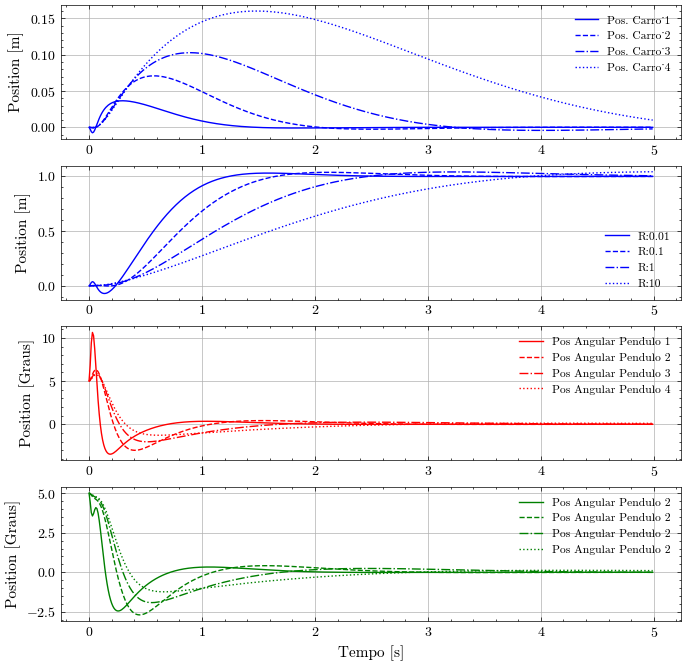

In [65]:
plt.figure(figsize=(8,8))
# Plot the the input delta(t) and the outputs: psi(t) and Y(t)
plt.subplot(4,1,1)
plt.plot(t_cmf_1,y_cmf_1[0],'-b',linewidth=1,label='Pos. Carro_1')
plt.plot(t_cmf_2,y_cmf_2[0],'--b',linewidth=1,label='Pos. Carro_2')
plt.plot(t_cmf_3,y_cmf_3[0],'-.b',linewidth=1,label='Pos. Carro_3')
plt.plot(t_cmf_4,y_cmf_4[0],':b',linewidth=1,label='Pos. Carro_4')
##plt.xlabel('t-tempo [s]',fontsize=11)
plt.ylabel('Position [m]',fontsize=11)
plt.grid(True)
plt.legend(loc='upper right',fontsize='small')

plt.subplot(4,1,2)
plt.plot(t_cmf_1_t,y_cmf_1_t[0][0],'-b',linewidth=1,label='R:0.01')
plt.plot(t_cmf_2_t,y_cmf_2_t[0][0],'--b',linewidth=1,label='R:0.1')
plt.plot(t_cmf_3_t,y_cmf_3_t[0][0],'-.b',linewidth=1,label='R:1')
plt.plot(t_cmf_4_t,y_cmf_4_t[0][0],':b',linewidth=1,label='R:10')
##plt.xlabel('t-tempo [s]',fontsize=11)
plt.ylabel('Position [m]',fontsize=11)
plt.grid(True)
plt.legend(loc='lower right',fontsize='small')

plt.subplot(4,1,3)
plt.plot(t_cmf_1,y_cmf_1[1]*180/np.pi,'-r',linewidth=1,label='Pos Angular Pendulo 1')
plt.plot(t_cmf_2,y_cmf_2[1]*180/np.pi,'--r',linewidth=1,label='Pos Angular Pendulo 2')
plt.plot(t_cmf_3,y_cmf_3[1]*180/np.pi,'-.r',linewidth=1,label='Pos Angular Pendulo 3')
plt.plot(t_cmf_4,y_cmf_4[1]*180/np.pi,':r',linewidth=1,label='Pos Angular Pendulo 4')
#plt.xlabel('t-tempo [s]',fontsize=11)
plt.ylabel('Position [Graus]',fontsize=11)
plt.grid(True)
plt.legend(loc='upper right',fontsize='small')

plt.subplot(4,1,4)
plt.plot(t_cmf_1,y_cmf_1[2]*180/np.pi,'-g',linewidth=1,label='Pos Angular Pendulo 2')
plt.plot(t_cmf_2,y_cmf_2[2]*180/np.pi,'--g',linewidth=1,label='Pos Angular Pendulo 2')
plt.plot(t_cmf_3,y_cmf_3[2]*180/np.pi,'-.g',linewidth=1,label='Pos Angular Pendulo 2')
plt.plot(t_cmf_4,y_cmf_4[2]*180/np.pi,':g',linewidth=1,label='Pos Angular Pendulo 2')
plt.xlabel('Tempo [s]',fontsize=11)
plt.ylabel('Position [Graus]',fontsize=11)
plt.grid(True)
plt.legend(loc='upper right',fontsize='small')

plt.show()

### Sistema Discreto

In [75]:
# Definindo o sistema discreto
sys_d_ma = ct.c2d(sys_c_ma, Ts,method='zoh')

Ad = sys_d_ma.A
Bd = sys_d_ma.B
Cd = sys_d_ma.C
Dd = sys_d_ma.D

print(sys_d_ma)

<StateSpace>: sys[0]$sampled
Inputs (1): ['u[0]']
Outputs (3): ['y[0]', 'y[1]', 'y[2]']
States (6): ['x[0]', 'x[1]', 'x[2]', 'x[3]', 'x[4]', 'x[5]']

A = [[ 1.00000000e+00 -7.28606355e-04  7.49412421e-05  9.99961347e-03
       5.48080144e-06 -4.23389011e-06]
     [ 0.00000000e+00  1.02168811e+00 -7.11581625e-03  4.90148910e-06
       9.76798844e-03  1.78681417e-04]
     [ 0.00000000e+00 -2.13474488e-02  1.01685092e+00 -1.51243677e-06
       3.67182507e-04  9.71799205e-03]
     [ 0.00000000e+00 -1.44499430e-01  1.43143490e-02  9.99922879e-01
       8.34524051e-04 -8.07734397e-04]
     [ 0.00000000e+00  4.28474748e+00 -1.39471031e+00  9.72078238e-04
       9.61630668e-01  3.27645395e-02]
     [ 0.00000000e+00 -4.18413093e+00  3.32525500e+00 -2.88886962e-04
       6.50354561e-02  9.50171292e-01]]

B = [[-3.86529542e-05]
     [ 4.90148910e-04]
     [-1.51243677e-04]
     [-7.71211741e-03]
     [ 9.72078238e-02]
     [-2.88886962e-02]]

C = [[1. 0. 0. 0. 0. 0.]
     [0. 1. 0. 0. 0. 0.]
    

In [48]:
ct.poles(sys_d_ma)

array([1.        +0.j, 0.71968262+0.j, 0.88812847+0.j, 1.22296832+0.j,
       1.11951779+0.j, 0.99996667+0.j])

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


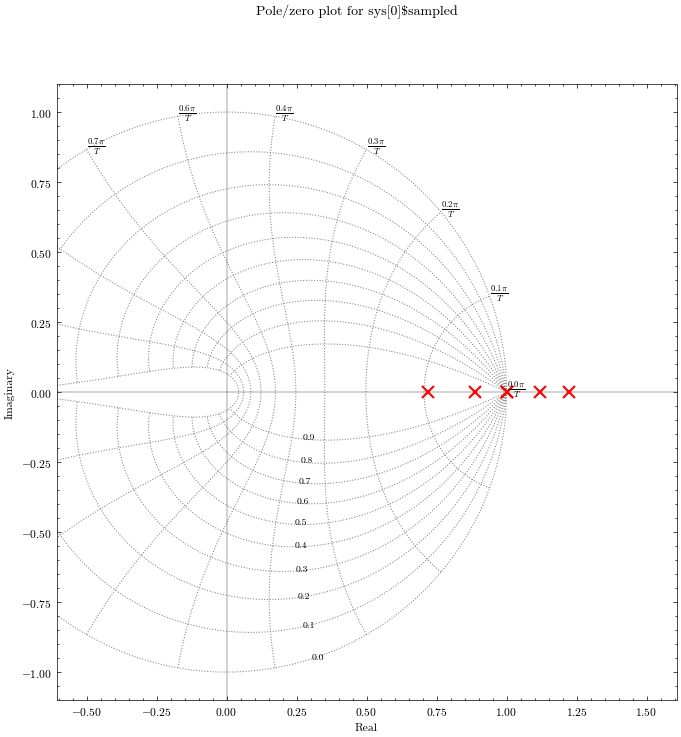

In [49]:
plt.figure(figsize=(8,8))
ct.pole_zero_plot(sys_d_ma, grid=True, color='r',marker_size=9,  xlim=[0,1])
plt.savefig('Cap2_Pzmap_sys_d_ma.png', dpi=200,bbox_inches='tight')


In [50]:
# Matriz de controlabilidade

Cod = ct.ctrb(Ad, Bd) # Sis Discreto

# Ranking da matriz de controlabilidade
ranking_Cod = np.linalg.matrix_rank(Cod)    
print('Rank da Matriz de controlabilidade:',ranking_Cod)
Cod

Rank da Matriz de controlabilidade: 6


array([[-3.86529542e-05, -1.15484519e-04, -1.92746466e-04,
        -2.71869226e-04, -3.54239381e-04, -4.41274769e-04],
       [ 4.90148910e-04,  1.44618076e-03,  2.40253776e-03,
         3.40419193e-03,  4.49377237e-03,  5.71431475e-03],
       [-1.51243677e-04, -4.09291145e-04, -6.42337307e-04,
        -8.99470004e-04, -1.22537661e-03, -1.66408584e-03],
       [-7.71211741e-03, -7.68005717e-03, -7.79602755e-03,
        -8.05151042e-03, -8.44603883e-03, -8.98621624e-03],
       [ 9.72078238e-02,  9.48351083e-02,  9.71804200e-02,
         1.03856371e-01,  1.14772945e-01,  1.30096498e-01],
       [-2.88886962e-02, -2.36787977e-02, -2.37410577e-02,
        -2.84241142e-02, -3.74856567e-02, -5.10282658e-02]])

In [51]:
# Matriz de observabilidade

Obd = ct.obsv(Ad, Cd) # Sis Discreto

ranking_Obd = np.linalg.matrix_rank(Obd)    
print('Rank da Matriz de observabilidade:',ranking_Obd)
Obd

Rank da Matriz de observabilidade: 6


array([[ 1.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  1.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 1.00000000e+00, -7.28606355e-04,  7.49412421e-05,
         9.99961347e-03,  5.48080144e-06, -4.23389011e-06],
       [ 0.00000000e+00,  1.02168811e+00, -7.11581625e-03,
         4.90148910e-06,  9.76798844e-03,  1.78681417e-04],
       [ 0.00000000e+00, -2.13474488e-02,  1.01685092e+00,
        -1.51243677e-06,  3.67182507e-04,  9.71799205e-03],
       [ 1.00000000e+00, -2.87835405e-03,  2.77745004e-04,
         1.99984586e-02,  1.17313718e-05, -1.55561768e-05],
       [ 0.00000000e+00,  1.08510352e+00, -2.75351519e-02,
         1.93632967e-05,  1.93820468e-02,  6.03222870e-04],
       [ 0.00000000e+00, -8.26054557e-02,  1.065

In [76]:
# Sintonia do Contolador Discreto

Kd, Sd, Pd = ct.dlqr(sys_d_ma, Q, R) # K - Ganhos do LQR

Kd

array([[  -7.17505465,  240.33534341, -255.23666312,   -8.02920303,
           1.10842292,  -11.7932137 ]])

In [77]:
Pd

array([0.72342698+0.j        , 0.80627289+0.j        ,
       0.88866573+0.03539712j, 0.88866573-0.03539712j,
       0.98809603+0.01147217j, 0.98809603-0.01147217j])

In [78]:
# Sistema em Malha fechada - Discreto

Ad_mf = Ad - Bd@Kd
Bd_mf = Bd
Cd_mf = Cd
Dd_mf = Dd

sys_d_mf = ct.ss(Ad_mf, Bd_mf, Cd_mf, Dd_mf, Ts)


print(sys_d_mf)


<StateSpace>: sys[8]
Inputs (1): ['u[0]']
Outputs (3): ['y[0]', 'y[1]', 'y[2]']
States (6): ['x[0]', 'x[1]', 'x[2]', 'x[3]', 'x[4]', 'x[5]']

A = [[ 9.99722663e-01  8.56106466e-03 -9.79070980e-03  9.68926105e-03
       4.83246216e-05 -4.60076439e-04]
     [ 3.51684522e-03  9.03887999e-01  1.17988156e-01  3.94040661e-03
       9.22469615e-03  5.95911226e-03]
     [-1.08518165e-03  1.50017524e-02  9.78247992e-01 -1.21587863e-03
       5.34824465e-04  7.93434304e-03]
     [-5.53348638e-02  1.70899496e+00 -1.95410076e+00  9.38000722e-01
       9.38281172e-03 -9.17583831e-02]
     [ 6.97471447e-01 -1.90777282e+01  2.34162903e+01  7.81473432e-01
       8.53883289e-01  1.17915718e+00]
     [-2.07277974e-01  2.75884379e+00 -4.04819941e+00 -2.32242094e-01
       9.70563490e-02  6.09480725e-01]]

B = [[-3.86529542e-05]
     [ 4.90148910e-04]
     [-1.51243677e-04]
     [-7.71211741e-03]
     [ 9.72078238e-02]
     [-2.88886962e-02]]

C = [[1. 0. 0. 0. 0. 0.]
     [0. 1. 0. 0. 0. 0.]
     [0. 0. 

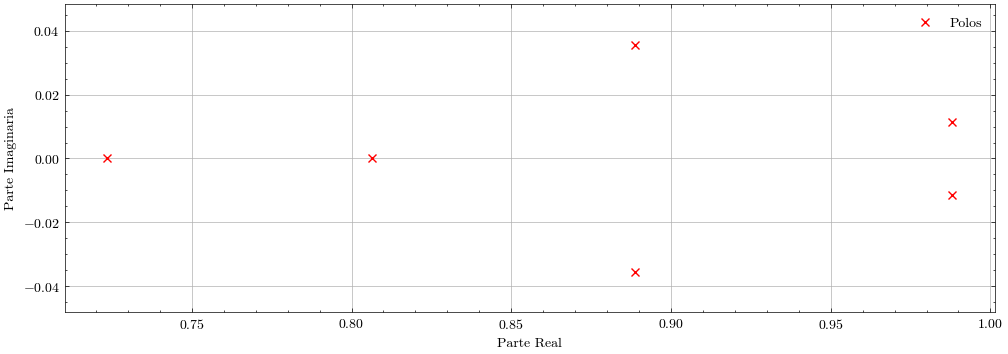

In [55]:
#  REPRESENTAÇÃO DOS POLOS NO PLANO DISCRETO

sys_discreto_real = np.real(Pd)
sys_discreto_imaginario = np.imag(Pd)

# Gráfico dos polos no plano complexo
plt.figure(figsize=(12, 4))
plt.plot(sys_discreto_real,sys_discreto_imaginario, 'rx', markersize=6, label='Polos')
plt.xlabel('Parte Real')
plt.ylabel('Parte Imaginaria')
plt.legend()
plt.grid(True)
plt.axis('equal')
plt.show()

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


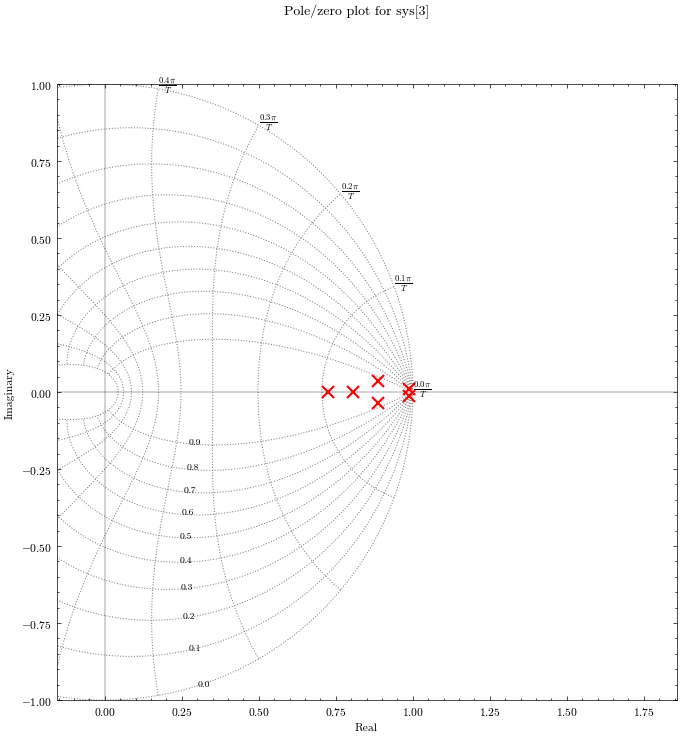

In [56]:
plt.figure(figsize=(8,8))
ct.pole_zero_plot(sys_d_mf, grid=True, color='r',marker_size=9,  xlim=[0.7,1],ylim=[-1,1])
plt.savefig('Cap4_Pzmap_sys_d_mf.png', dpi=300,bbox_inches='tight')

In [79]:
# Simulações

# Simular o sistema linear discreto para condições iniciais

t_d_mf = np.arange(0, 4, Ts) 
x0_d_mf = np.array([[0.5],[np.deg2rad(5)],[-np.deg2rad(5)],[0],[0],[0]])

t_dmd,y_dmf, x_dmf = ct.initial_response(sys_d_mf, t_d_mf, x0_d_mf, return_x=True)


In [80]:
# Esforço de controle
u#[k] = - Kd*x[k]
#sinal_de_controle  = - x_dmf * Kd.transpose()
sinal_de_controle = -(Kd @ x_dmf.T.T).flatten()
np.max(sinal_de_controle)

np.float64(16.76612968070196)

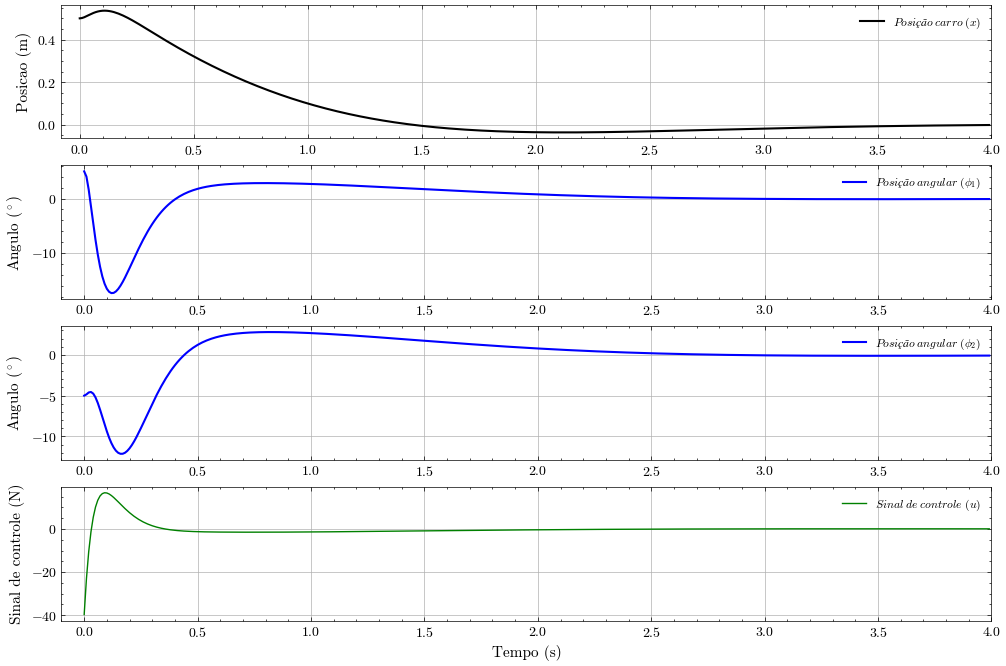

In [81]:
plt.figure(figsize=(12,8))
# Plot the the input delta(t) and the outputs: psi(t) and Y(t)
plt.subplot(4,1,1)
plt.plot(t_dmd,y_dmf[0],'k',linewidth=1.5,label='$Posição\\;carro\\;$$(x)$')
#plt.ylim([-0.01, 0.1])
plt.xlim([-0.08, 4])
##plt.xlabel('t-tempo [s]',fontsize=11)
plt.ylabel('Posicao (m)',fontsize=11)
plt.grid(True)
plt.legend(loc='upper right',fontsize='small')

plt.subplot(4,1,2)
plt.plot(t_dmd,y_dmf[1]*180/np.pi,'b',linewidth=1.5,label='$Posição\\;angular\\;$$(\\phi_1)$')
#plt.xlabel('t-tempo [s]',fontsize=11)
plt.ylabel('Angulo ($^\\circ$)',fontsize=11)
plt.xlim([-0.1, 4])
plt.grid(True)
plt.legend(loc='upper right',fontsize='small')

plt.subplot(4,1,3)
plt.plot(t_dmd,y_dmf[2]*180/np.pi,'b',linewidth=1.5,label='$Posição\\;angular\\;$$(\\phi_2)$')
plt.ylabel('Angulo ($^\\circ$)',fontsize=11)
plt.xlim([-0.1, 4])
plt.grid(True)
plt.legend(loc='upper right',fontsize='small')

plt.subplot(4,1,4)
#plt.step(t_dmd, sinal_de_controle,'g', label = 'Sinal de controle')
plt.plot(t_dmd, sinal_de_controle,'g', label = '$Sinal\\;de\\;controle$ $(u)$')
plt.xlim([-0.1, 4])
plt.ylabel('Sinal de controle (N)',fontsize=11, color='k')
plt.xlabel('Tempo (s)',fontsize=11)
plt.legend(loc='upper right',fontsize='small')
plt.grid(True)

plt.savefig('Cap4_lqr_L_caso3_sys_d_mf.png', dpi=500,bbox_inches='tight')
plt.show()


## LQR Não Linear

In [73]:
A_nolinear = sym.Matrix(((0,0,0,1,0,0),(0,0,0,0,1,0),(0,0,0,0,0,1)))
A_nolinear

Matrix([
[0, 0, 0, 1, 0, 0],
[0, 0, 0, 0, 1, 0],
[0, 0, 0, 0, 0, 1]])

In [74]:
Anl_0 = Anl.jacobian(q_ef)
Anl_1 = Anl_0.subs(rev_parametros_valores)
Anl_1


Matrix([
[0,                                                                                                                                                                                                                                    0,                                                                                                                                                                                                                                      0,                    1,                                                                                                                                          0,                                                                                                                                           0],
[0,                                                                                                                                                                                                                          

36

In [75]:
Bnl_1 = Bnl.subs(rev_parametros_valores)
Bnl_2 = Bnl_1.subs({u:1})
Bnl_2

Matrix([
[                 0],
[                 0],
[                 0],
[-0.778148791774192],
[   10.013364530616],
[ -3.35116608539655]])

In [103]:
K= Kc1

In [104]:
# Dinâmica não linear do sistema
def nlodek(xs_, t, K, Anl, Bnl):
    A_nlode = np.array(Anl.subs({x: xs_[0], phi1: xs_[1], phi2: xs_[2], x_d: xs_[3], phi1_d: xs_[4], phi2_d: xs_[5]})).astype(np.float64)
    B_nlode = np.array(Bnl.subs({x: xs_[0], phi1: xs_[1], phi2: xs_[2], x_d: xs_[3], phi1_d: xs_[4], phi2_d: xs_[5]})).astype(np.float64)
   
    u_lqr =-K@xs_  # Controlador LQR
    
    dxdt = np.dot(A_nlode, xs_) + np.dot(B_nlode, u_lqr)
    
    return dxdt.flatten()


In [106]:
# Dinâmica não linear do sistema
def nlodek_tracking(xs_, t, K, Anl, Bnl):
    A_nlode = np.array(Anl.subs({x: xs_[0], phi1: xs_[1], phi2: xs_[2], x_d: xs_[3], phi1_d: xs_[4], phi2_d: xs_[5]})).astype(np.float64)
    B_nlode = np.array(Bnl.subs({x: xs_[0], phi1: xs_[1], phi2: xs_[2], x_d: xs_[3], phi1_d: xs_[4], phi2_d: xs_[5]})).astype(np.float64)
   
    u_lqr =-K@xs_  # Controlador LQR
    
   
    dxrdtr = np.dot(A_nlode, xs_) + np.dot(B_nlode, u_lqr[0])
    return dxrdtr.flatten()

In [107]:
# Simular modelo não linear com odeint
x0 = [1.0, np.deg2rad(5), np.deg2rad(5),0,0,0]
#t = np.linspace(0, 5, 500)
t = np.arange(0, 4, Ts) 
xs_ = odeint(nlodek, x0, t, args=(K, Anl_1, Bnl_2))
xs_r = odeint(nlodek_tracking,x0,t,args=(K, Anl_1, Bnl_2))
u_lqr_historico = -(K @ xs_.T).flatten()

/tmp/ipykernel_2376/1019398790.py:5: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  xs_ = odeint(nlodek, x0, t, args=(K, Anl_1, Bnl_2))


RuntimeError: The size of the array returned by func (36) does not match the size of y0 (6).

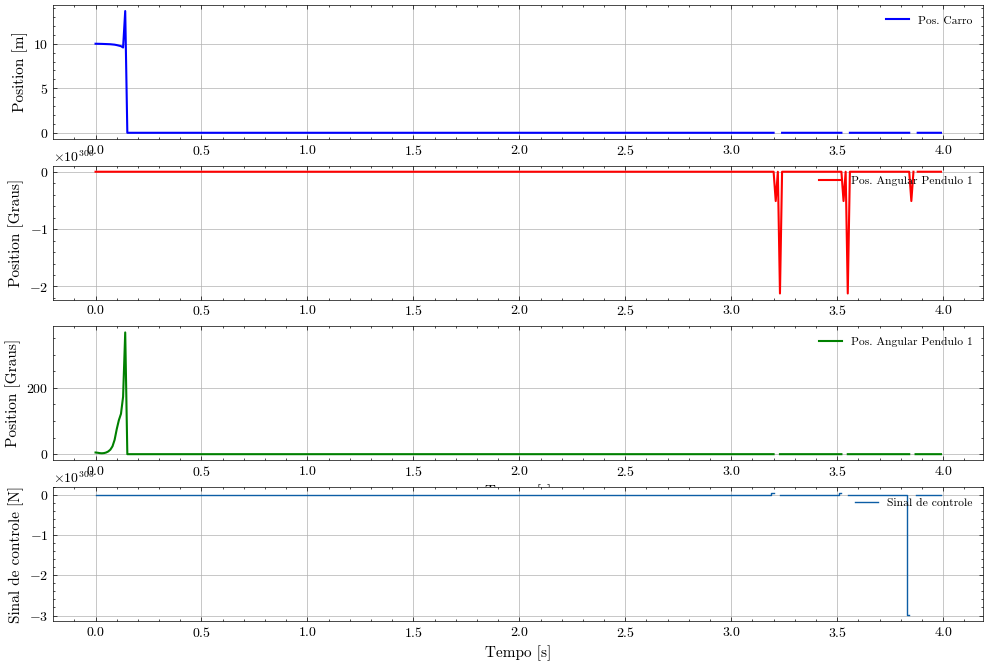

In [139]:
plt.figure(figsize=(12,8))
# Plot the the input delta(t) and the outputs: psi(t) and Y(t)
plt.subplot(4,1,1)
plt.plot(t,xs_.T[0],'b',linewidth=1.5,label='Pos. Carro')
#plt.xlabel('t-tempo [s]',fontsize=11)
plt.ylabel('Position [m]',fontsize=11)
plt.grid(True)
plt.legend(loc='upper right',fontsize='small')

plt.subplot(4,1,2)
plt.plot(t,xs_.T[1]*180/np.pi,'r',linewidth=1.5,label='Pos. Angular Pendulo 1')
#plt.xlabel('t-tempo [s]',fontsize=11)
plt.ylabel('Position [Graus]',fontsize=11)
plt.grid(True)
plt.legend(loc='upper right',fontsize='small')

plt.subplot(4,1,3)
plt.plot(t,xs_.T[2]*180/np.pi,'g',linewidth=1.5,label='Pos. Angular Pendulo 1')
plt.xlabel('Tempo [s]',fontsize=11)
plt.ylabel('Position [Graus]',fontsize=11)
plt.grid(True)
plt.legend(loc='upper right',fontsize='small')

plt.subplot(4,1,4)
plt.step(t, u_lqr_historico, label = 'Sinal de controle')
plt.ylabel('Sinal de controle [N]',fontsize=11, color='k')
plt.xlabel('Tempo [s]',fontsize=11)
plt.legend(loc='upper right',fontsize='small')
plt.grid(True)

plt.show()

## Comparação - Linear x Não Linear



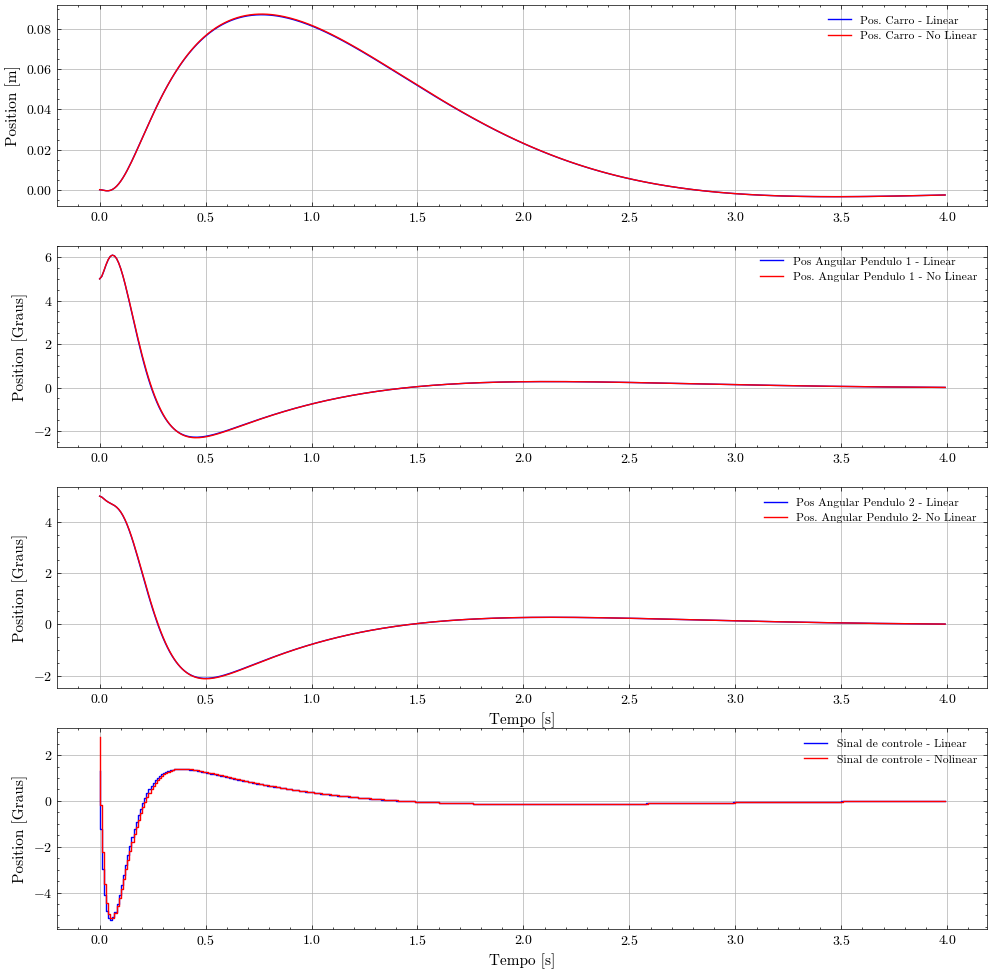

In [137]:
plt.figure(figsize=(12,12))
# Plot the the input delta(t) and the outputs: psi(t) and Y(t)
plt.subplot(4,1,1)
plt.plot(t_dmd,y_dmf[0],'b',linewidth=1,label='Pos. Carro - Linear')
plt.plot(t,xs_.T[0],'-r',linewidth=1,label='Pos. Carro - No Linear')
#plt.xlabel('t-tempo [s]',fontsize=11)
plt.ylabel('Position [m]',fontsize=11)
plt.grid(True)
plt.legend(loc='upper right',fontsize='small')

plt.subplot(4,1,2)
plt.plot(t_dmd,y_dmf[1]*180/np.pi,'b',linewidth=1,label='Pos Angular Pendulo 1 - Linear')
plt.plot(t,xs_.T[1]*180/np.pi,'-r',linewidth=1,label='Pos. Angular Pendulo 1 - No Linear')
#plt.xlabel('t-tempo [s]',fontsize=11)
plt.ylabel('Position [Graus]',fontsize=11)
plt.grid(True)
plt.legend(loc='upper right',fontsize='small')

plt.subplot(4,1,3)
plt.plot(t_dmd,y_dmf[2]*180/np.pi,'b',linewidth=1,label='Pos Angular Pendulo 2 - Linear')
plt.plot(t,xs_.T[2]*180/np.pi,'-r',linewidth=1,label='Pos. Angular Pendulo 2- No Linear')
plt.xlabel('Tempo [s]',fontsize=11)
plt.ylabel('Position [Graus]',fontsize=11)
plt.grid(True)
plt.legend(loc='upper right',fontsize='small')

plt.subplot(4,1,4)
plt.step(t_dmd, sinal_de_controle,'b', label = 'Sinal de controle - Linear')
plt.step(t, u_lqr_historico, '-r',label = 'Sinal de controle - Nolinear')
plt.xlabel('Tempo [s]',fontsize=11)
plt.ylabel('Position [Graus]',fontsize=11)
plt.grid(True)
plt.legend(loc='upper right',fontsize='small')

plt.show()

/tmp/ipykernel_59796/1149463500.py:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='upper right',fontsize='small')
/tmp/ipykernel_59796/1149463500.py:15: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='upper right',fontsize='small')
/tmp/ipykernel_59796/1149463500.py:22: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='upper right',fontsize='small')


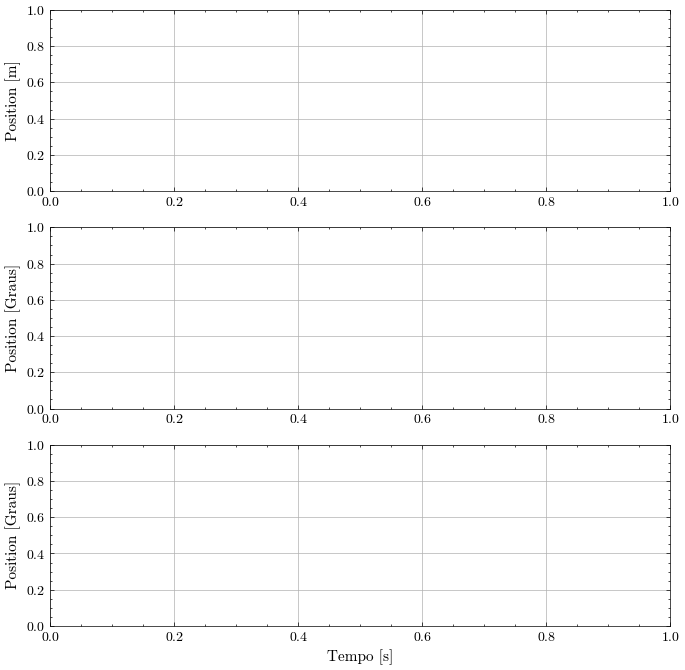

In [80]:
plt.figure(figsize=(8,8))
# Plot the the input delta(t) and the outputs: psi(t) and Y(t)
plt.subplot(3,1,1)

##plt.xlabel('t-tempo [s]',fontsize=11)
plt.ylabel('Position [m]',fontsize=11)
plt.grid(True)
plt.legend(loc='upper right',fontsize='small')

plt.subplot(3,1,2)

#plt.xlabel('t-tempo [s]',fontsize=11)
plt.ylabel('Position [Graus]',fontsize=11)
plt.grid(True)
plt.legend(loc='upper right',fontsize='small')

plt.subplot(3,1,3)

plt.xlabel('Tempo [s]',fontsize=11)
plt.ylabel('Position [Graus]',fontsize=11)
plt.grid(True)
plt.legend(loc='upper right',fontsize='small')

plt.show()

Dinâmica Linear

In [ ]:
# Matriz H de Massas do sistema:
H = sym.Matrix((sym.diff(eq_x,q_dd),sym.diff(eqn_phi1,q_dd),sym.diff(eqn_phi2,q_dd))).subs(ponto_eq)

# Matriz H inversa
H_inv = H.inv()
H

In [ ]:
# Matriz de efeito corolis e atritos viscosos
N = sym.Matrix((sym.diff(eq_x,q_d),sym.diff(eqn_phi1,q_d),sym.diff(eqn_phi2,q_d))).subs(ponto_eq)
N

In [ ]:
# Matriz dos efeitos das massas e da gravidade
W = sym.Matrix([0,-g*l1*sym.sin(phi1)*(m1+2*m2),-g*m2*l2*sym.sin(phi2)]).subs({sym.sin(phi1): phi1,sym.sin(phi2): phi2})
W

In [ ]:
# Matriz de entradas

V = sym.Matrix([u_l,0,0])
V

In [ ]:
N*q_d.transpose()

In [ ]:
# Multiplicação matricial

C = N*q_d.transpose() + W # C+W

S = (H_inv*C)#.subs(ponto_eq)
S

In [ ]:
q_dd

In [ ]:
# Criando a Matriz de estados A
A_0 = sym.Matrix([q_dd.transpose(),S])
A_1 = A_0.jacobian(q_ef)
A_1

In [ ]:
# Criando a Matriz de estados B
B_0 = sym.Matrix([q_dd.transpose(),H_inv*V])
B_1 = B_0.jacobian([u_l])
B_1

In [ ]:
# Retorna as variveis para simbolo novamente:
M, m1, m2, l1, l2,J1, J2, g, t, f0, f1, f2 = sym.symbols('M m1 m2 l1 l2 J1 J2 g t  f0 f1 f2')

In [ ]:
# Valor dos parâmetros do sistema:
valor_param_dGisele = {M:1,m1:1,m2:1,J1:0.00083,J2:0.00083,\
               l1:0.05,l2:0.05,g:9.81,f0:0.01,f1:0.007,f2:0.007}


In [ ]:
# Matriz A - Substituindo os parâmetros
A_s = A_1.subs(valor_param_dGisele)
A = np.matrix(A_s).astype(np.float64)
A

In [ ]:
# Matriz B
B_s = B_1.subs(valor_param_dGisele)
B = np.matrix(B_s).astype(np.float64)
B

In [ ]:
# Matriz C
C = np.array([[1, 0, 0, 0, 0, 0],
              [0, 1, 0, 0, 0, 0],
              [0, 0, 1, 0, 0, 0]])

# Matriz D
D = np.zeros((3,1))

In [ ]:
s_lin_ma = ct.ss(A,B,C,D)
s_lin_ma

In [ ]:
# Polos do sistema
polos = ct.poles(s_lin_ma)
zeros_s = ct.zeros(s_lin_ma)
print('Os polos do sistema são: ', polos \
    , 'Os zeros do sistema são: ',zeros_s)

# 2 Dinâmica Linear


In [ ]:
sys_d_ma

In [ ]:
# Polos do sistema
polos = ct.poles(sys_d_ma)
zeros_s = ct.zeros(sys_d_ma)
print('Os polos do sistema são: ', polos \
    , 'Os zeros do sistema são: ',zeros_s)

In [ ]:
# Pólos do sistema ma discreto
plt.figure(figsize=(12, 12)) 
ct.pzmap(s_lin_ma,grid=True, color='r',marker_size=6.4)

In [ ]:
sys_c_ma

In [ ]:
# Pólos do sistema ma discreto
plt.figure(figsize=(12, 12)) 
ct.pzmap(sys_c_ma,grid=True, color='r',marker_size=6.4)

In [ ]:
# Pólos do sistema ma discreto

plt.figure(figsize=(6, 6)) 
ct.pzmap(sys_d_ma,plot=True,title ='Polos do sistema',grid=True,color='r',marker_size=6.4,xlim=[0.5,1.2],ylim=[-0.3,0.3],scaling=True)


In [ ]:
# Plotar resposta inicial do sistema

x0 = np.array([[0.0],[0.0],[0.1],[0],[0],[0]])
tp = np.arange(0, 3, Ts) 
#t,y = ct.initial_response(sys, tp,x0) # Resposta Inicial
t,y = ct.initial_response(sys_discreto, tp,x0) # Resposta Inicial
r,d = ct.step_response(sys,tp,x0) # Resposta ao degrau

In [ ]:
plt.style.reload_library

In [ ]:
plt.style.available

In [ ]:
altura = 4
largura = 9

plt.style.use(['seaborn-v0_8-ticks'])
#plt.style.use(['science','seaborn-v0_8-whitegrid'])
subplots = plt.subplots(1, 1, figsize=(largura, altura))
subplots[1].plot(t,y[0], '-r',label='Posicao do carro [m]')
subplots[1].plot(t,y[1], '-g',label=r'$\hat{A}$ngulo do pendulo inferior [rad]')
subplots[1].plot(t,y[2], label=r'$\hat{A}$ngulo do pendulo superior[rad]')
subplots[1].set_title('Resposta Inicial')
subplots[1].set_xlabel('Tempo (s)')
subplots[1].set_ylabel('Posicao (m)')
subplots[1].grid(True)
subplots[1].legend()
plt.show()



In [ ]:
altura = 4
largura = 9
subplots = plt.subplots(1, 1, figsize=(largura, altura))
#subplots[1].plot(t,d[0][0], label='x')
subplots[1].plot(t,d[1][0], label='angulo phi1')
subplots[1].plot(t,d[2][0], label='angulo phi2')
subplots[1].set_title('Resposta ao Degrau')
subplots[1].set_xlabel('Tempo (s)')
subplots[1].set_ylabel('Posição [rad]')
subplots[1].grid(True)
subplots[1].legend()
plt.show()